In [381]:
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from sklearn.preprocessing import MinMaxScaler
from matplotlib import pyplot as plt

In [382]:
url='https://raw.githubusercontent.com/NayantaraPrem/EthereumPricePrediction/master/Dataset.csv'
df = pd.read_csv(url)
df.head(4)

,Date(UTC),UnixTimeStamp,BlockSize,AvgGasPrices,GasUsed,GasLimit,BlockTime,NetworkUtilization,TransactionFees,BlockDifficulty,NetworkHash,EtherSupply,MarketCap,AddressCount,Price,EthereumGTrends,TweetCount
0,7/30/2015,1.438214e+09,644.0,0.0,0.0,0.0,4.46,0.0,0.0,0.121,11.5297,72049306.59,0.0,9205.0,0.0,0.61,NaN
1,7/31/2015,1.438301e+09,582.0,0.0,0.0,0.0,12.58,0.0,0.0,0.603,51.4594,72085498.31,0.0,9361.0,0.0,1.00,NaN
2,8/1/2015,1.438387e+09,575.0,0.0,0.0,0.0,16.34,0.0,0.0,0.887,57.7845,72113204.25,0.0,9476.0,0.0,0.94,NaN
3,8/2/2015,1.438474e+09,581.0,0.0,0.0,0.0,16.12,0.0,0.0,1.020,67.9224,72141427.69,0.0,9563.0,0.0,0.71,NaN


In [383]:
output_column = 'Price'
X = df.drop(['Date(UTC)', 'UnixTimeStamp'], axis=1)

#drop rows with NaN values
X = X.dropna()

n_timesteps = 7 
n_features = len(X.columns)
n_outputs = 1 # no. of days to predict
N = len(X)

In [384]:
test_split = 0.2 #20% test, 80% train
X_test = X[0:round(N*test_split)]
X_train = X[0:round(N*(1-test_split))]
N_test = X_test.shape[0]
N_train = X_train.shape[0]

In [385]:
#scale training data
# input = 3 features. Column 4 shifted is output
input_scaler = MinMaxScaler(feature_range = (0, 1))
X_train_scaled = pd.DataFrame(input_scaler.fit_transform(X_train), columns=X_train.columns)
output_scaler = MinMaxScaler(feature_range = (0, 1))
output_scaler.fit(np.array(X_train[output_column]).reshape((N_train,1))) # scaling the output column
X_train_scaled.head()

,BlockSize,AvgGasPrices,GasUsed,GasLimit,BlockTime,NetworkUtilization,TransactionFees,BlockDifficulty,NetworkHash,EtherSupply,MarketCap,AddressCount,Price,EthereumGTrends,TweetCount
0,0.003111,0.018726,0.003052,0.561650,0.034360,0.004988,0.001147,0.000000,0.000000,0.000000,0.003218,0.000000,0.004520,0.016834,0.012554
1,0.006345,0.021071,0.006098,0.561768,0.023104,0.009763,0.002482,0.000073,0.000160,0.001198,0.002180,0.000030,0.003229,0.019238,0.013062
2,0.005791,0.019562,0.004217,0.561627,0.038507,0.007323,0.001746,0.000145,0.000110,0.002369,0.001954,0.000063,0.002946,0.015631,0.011342
3,0.008594,0.022807,0.011290,0.561645,0.015995,0.018359,0.004638,0.000244,0.000331,0.003570,0.001840,0.000085,0.002800,0.013226,0.007822
4,0.007115,0.019940,0.008982,0.561650,0.027844,0.014857,0.003166,0.000458,0.000435,0.004752,0.001555,0.000111,0.002445,0.009118,0.014881


In [386]:
# restructure data: model expects input data X to have shape : samples x timesteps x features
# samples = N - n_timesteps
# each sample is a n_timesteps x n_features matrix of data that is used to make a single prediction
# eg. 7 days worth of daily data if n_timesteps = 7 is used to predict the 8th day value
# Y should be samples x output dimensions
X_train_windows = []
y_train_windows = []
for i in range(N_train - n_timesteps):
    X_train_windows.append(np.array(X_train_scaled.loc[i:i+n_timesteps-1]))
    y_train_windows.append(np.array(X_train_scaled.loc[i+n_timesteps, X_train_scaled.columns == output_column]))

X_train_windows = np.array(X_train_windows)
y_train_windows = np.array(y_train_windows)
X_train_windows.shape, y_train_windows.shape

((1007, 7, 15), (1007, 1))

In [387]:
#define the model
model = Sequential()
model.add(LSTM(
    50,
    activation='relu',
    return_sequences=True))
model.add(LSTM(50, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# train model
model.fit(X_train_windows, y_train_windows, epochs=100, verbose=0)

In [388]:
# test prediction

#scale the input to [0,1]
X_test_scaled = pd.DataFrame(input_scaler.fit_transform(X_test), columns=X_test.columns)

#build the windows
X_test_windows = []
y_test_windows = []
for i in range(N_test - n_timesteps):
    X_test_windows.append(np.array(X_test_scaled.loc[i:i+n_timesteps-1]))
    y_test_windows.append(np.array(X_test_scaled.loc[i+n_timesteps, X_test_scaled.columns == output_column]))

X_test_windows = np.array(X_test_windows)
y_test_windows = np.array(y_test_windows)
X_test_windows.shape, y_test_windows.shape

((246, 7, 15), (246, 1))

In [389]:
#run predictions on each window
y_pred = []
for X_test_window in X_test_windows:
    y_pred.append(model.predict(X_test_window.reshape(1,n_timesteps,n_features))[0])
y_pred = np.array(y_pred)

# rescale the predictions back to the original values
y_pred_scaled = output_scaler.inverse_transform(y_pred)
y_actual_scaled = output_scaler.inverse_transform(y_test_windows)

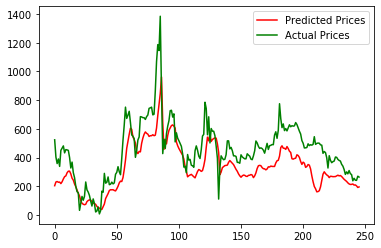

In [390]:
plt.plot(y_pred_scaled, color='red', label='Predicted Prices')
plt.plot(y_actual_scaled, color='green', label='Actual Prices')
plt.legend()
plt.show()